# GeoGuessr Competition - Main Training Notebook

This notebook orchestrates the full training pipeline for the GeoGuessr StreetView competition.

**Competition Task:**
- State Classification (70% of score): Predict US state from 4 street view images
- GPS Regression (30% of score): Predict latitude/longitude coordinates

**Model Architecture:**
- Backbone: StreetCLIP (CLIP ViT-L/14-336 fine-tuned on street imagery)
- Fusion: Simple embedding averaging (PIGEON's best approach)
- Heads: Classification (33 states) + GPS regression

## 1. Setup & Configuration

In [1]:
import sys
sys.path.insert(0, '.')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Check GPU
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.9.1
CUDA available: False


In [2]:
# Import our modules
from src.config import get_config, STATE_INDEX_TO_NAME
from src.utils.seed import set_seed

# Get configuration
config = get_config()

# Set seed for reproducibility
set_seed(config.training.seed)

# Set device
device = torch.device(config.device)
print(f"Using device: {device}")

Random seed set to 42
Using device: cpu


In [3]:
# Adjust config for your hardware
# For A100 80GB, you can use larger batch sizes

# config.training.batch_size = 64  # Increase if you have more VRAM
# config.training.gradient_accumulation_steps = 2  # Effective batch = 128

print("Current configuration:")
print(f"  Batch size: {config.training.batch_size}")
print(f"  Gradient accumulation: {config.training.gradient_accumulation_steps}")
print(f"  Effective batch size: {config.training.batch_size * config.training.gradient_accumulation_steps}")
print(f"  Backbone: {config.model.backbone_name}")
print(f"  Fusion method: {config.model.fusion_method}")
print(f"  Haversine smoothing: {config.training.use_haversine_smoothing}")
print(f"  Haversine temperature: {config.training.haversine_temperature} km")

Current configuration:
  Batch size: 32
  Gradient accumulation: 4
  Effective batch size: 128
  Backbone: geolocal/StreetCLIP
  Fusion method: average
  Haversine smoothing: True
  Haversine temperature: 300.0 km


## 2. Data Exploration

In [4]:
# Load training data CSV
train_df = pd.read_csv(config.paths.train_csv)
print(f"Training samples: {len(train_df)}")
print(f"\nColumns: {list(train_df.columns)}")
train_df.head()

Training samples: 65980

Columns: ['sample_id', 'image_north', 'image_east', 'image_south', 'image_west', 'state', 'state_idx', 'latitude', 'longitude']


,sample_id,image_north,image_east,image_south,image_west,state,state_idx,latitude,longitude
0,0,img_000000_north.jpg,img_000000_east.jpg,img_000000_south.jpg,img_000000_west.jpg,Maine,18,43.472421,-70.719764
1,1,img_000001_north.jpg,img_000001_east.jpg,img_000001_south.jpg,img_000001_west.jpg,Kentucky,16,37.138246,-83.370471
2,2,img_000002_north.jpg,img_000002_east.jpg,img_000002_south.jpg,img_000002_west.jpg,Delaware,7,39.623170,-75.646469
3,3,img_000003_north.jpg,img_000003_east.jpg,img_000003_south.jpg,img_000003_west.jpg,Maryland,19,39.062109,-76.938240
4,4,img_000004_north.jpg,img_000004_east.jpg,img_000004_south.jpg,img_000004_west.jpg,Michigan,21,42.649931,-83.177384


In [5]:
# State distribution
state_counts = train_df['state'].value_counts()
print(f"Number of unique states: {len(state_counts)}")
print(f"\nState distribution:")
print(state_counts)

Number of unique states: 33

State distribution:
state
Minnesota        2000
Kansas           2000
Hawaii           2000
Louisiana        2000
Colorado         2000
Iowa             2000
Wisconsin        2000
Indiana          2000
Connecticut      2000
Kentucky         2000
Massachusetts    2000
South Dakota     2000
Nevada           2000
Georgia          2000
Alaska           2000
Washington       2000
Tennessee        2000
Florida          2000
Texas            2000
California       2000
Utah             2000
West Virginia    2000
Maryland         2000
Delaware         2000
Alabama          2000
Virginia         1999
Arkansas         1999
Illinois         1999
Vermont          1998
Michigan         1998
Idaho            1997
Wyoming          1995
Maine            1995
Name: count, dtype: int64


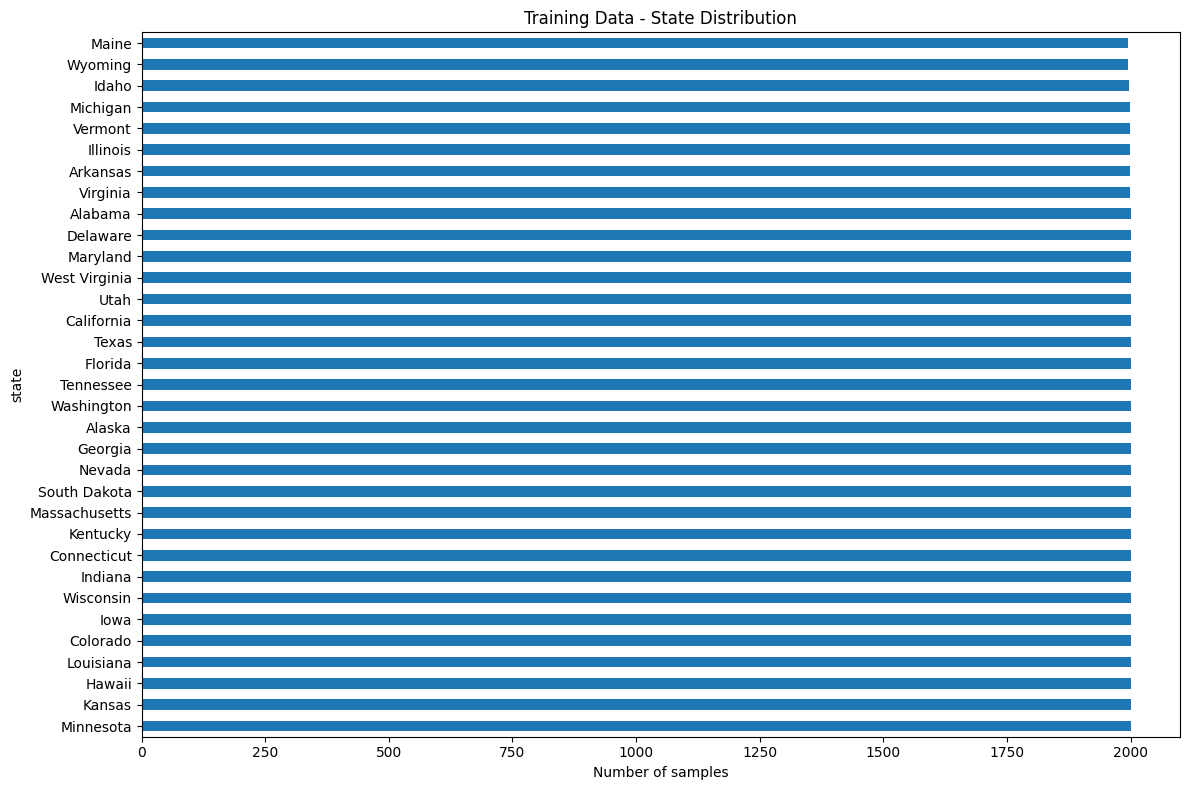

In [6]:
# Visualize state distribution
fig, ax = plt.subplots(figsize=(12, 8))
state_counts.plot(kind='barh', ax=ax)
ax.set_xlabel('Number of samples')
ax.set_title('Training Data - State Distribution')
plt.tight_layout()
plt.show()

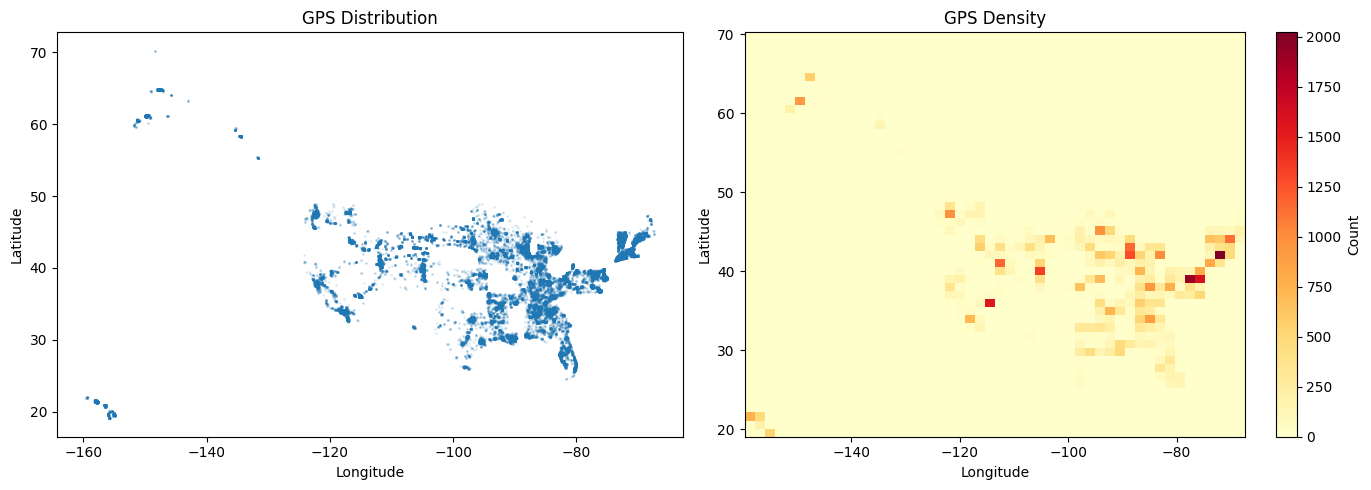

Latitude range: 19.07 to 70.23
Longitude range: -159.67 to -67.36


In [7]:
# GPS coordinate distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(train_df['longitude'], train_df['latitude'], alpha=0.1, s=1)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('GPS Distribution')

# Histograms
axes[1].hist2d(train_df['longitude'], train_df['latitude'], bins=50, cmap='YlOrRd')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('GPS Density')
plt.colorbar(axes[1].collections[0], ax=axes[1], label='Count')

plt.tight_layout()
plt.show()

print(f"Latitude range: {train_df['latitude'].min():.2f} to {train_df['latitude'].max():.2f}")
print(f"Longitude range: {train_df['longitude'].min():.2f} to {train_df['longitude'].max():.2f}")

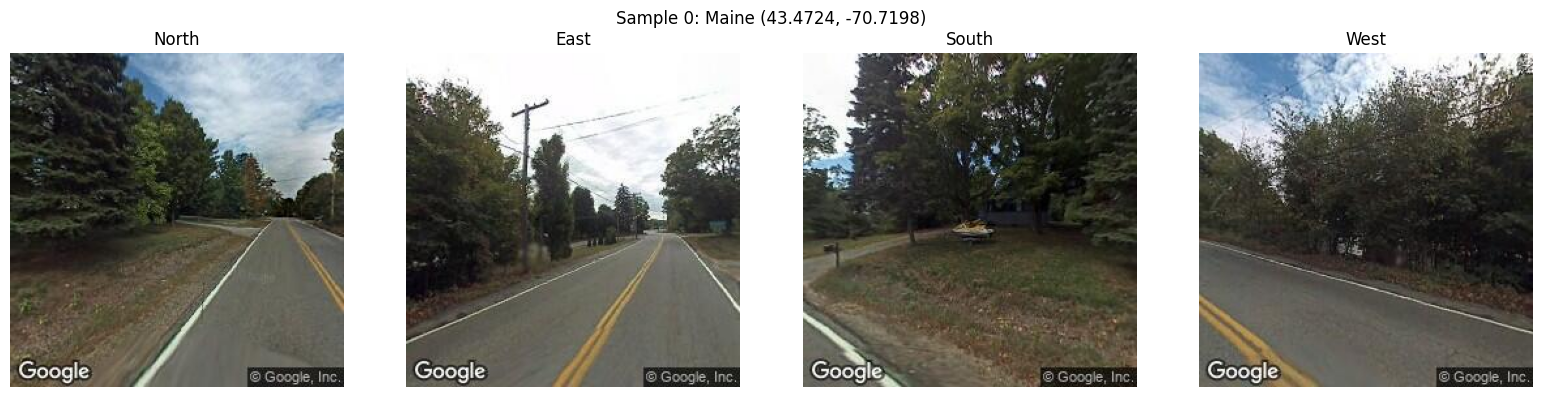

In [8]:
# Visualize some sample images
from PIL import Image

sample_idx = 0
sample = train_df.iloc[sample_idx]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
directions = ['north', 'east', 'south', 'west']

for ax, direction in zip(axes, directions):
    img_path = config.paths.train_images / sample[f'image_{direction}']
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(direction.capitalize())
    ax.axis('off')

plt.suptitle(f"Sample {sample_idx}: {sample['state']} ({sample['latitude']:.4f}, {sample['longitude']:.4f})")
plt.tight_layout()
plt.show()

## 3. Data Preparation

In [9]:
from src.data.state_utils import (
    compute_state_centroids,
    compute_haversine_matrix,
    haversine_distance
)

# Compute state centroids
centroids = compute_state_centroids(train_df, config.paths.state_centroids)
print(f"Computed centroids for {len(centroids)} states")

# Show some centroids
for state_idx, (lat, lon) in list(centroids.items())[:5]:
    state_name = STATE_INDEX_TO_NAME.get(state_idx, f"Unknown ({state_idx})")
    print(f"  {state_name}: ({lat:.2f}, {lon:.2f})")

Computed centroids for 33 states
  Maine: (44.13, -69.90)
  Kentucky: (37.89, -85.38)
  Delaware: (39.16, -75.52)
  Maryland: (39.12, -76.77)
  Michigan: (42.61, -83.96)


In [10]:
# Create state index mapping (original indices to contiguous 0-32)
unique_states = sorted(train_df['state_idx'].unique())
state_to_idx = {s: i for i, s in enumerate(unique_states)}
idx_to_state = {i: s for s, i in state_to_idx.items()}

print(f"Number of states: {len(state_to_idx)}")
print(f"\nMapping (first 10):")
for orig, cont in list(state_to_idx.items())[:10]:
    name = STATE_INDEX_TO_NAME.get(orig, "Unknown")
    print(f"  {orig} ({name}) -> {cont}")

Number of states: 33

Mapping (first 10):
  0 (Alabama) -> 0
  1 (Alaska) -> 1
  3 (Arkansas) -> 2
  4 (California) -> 3
  5 (Colorado) -> 4
  6 (Connecticut) -> 5
  7 (Delaware) -> 6
  8 (Florida) -> 7
  9 (Georgia) -> 8
  10 (Hawaii) -> 9


In [11]:
# Compute haversine distance matrix between state centroids
distance_matrix = compute_haversine_matrix(
    centroids, state_to_idx, config.paths.haversine_matrix
)

print(f"Distance matrix shape: {distance_matrix.shape}")
print(f"\nExample distances (km):")
print(f"  Min non-zero: {distance_matrix[distance_matrix > 0].min():.0f} km")
print(f"  Max: {distance_matrix.max():.0f} km")
print(f"  Mean: {distance_matrix.mean():.0f} km")

Distance matrix shape: (33, 33)

Example distances (km):
  Min non-zero: 108 km
  Max: 8192 km
  Mean: 2047 km


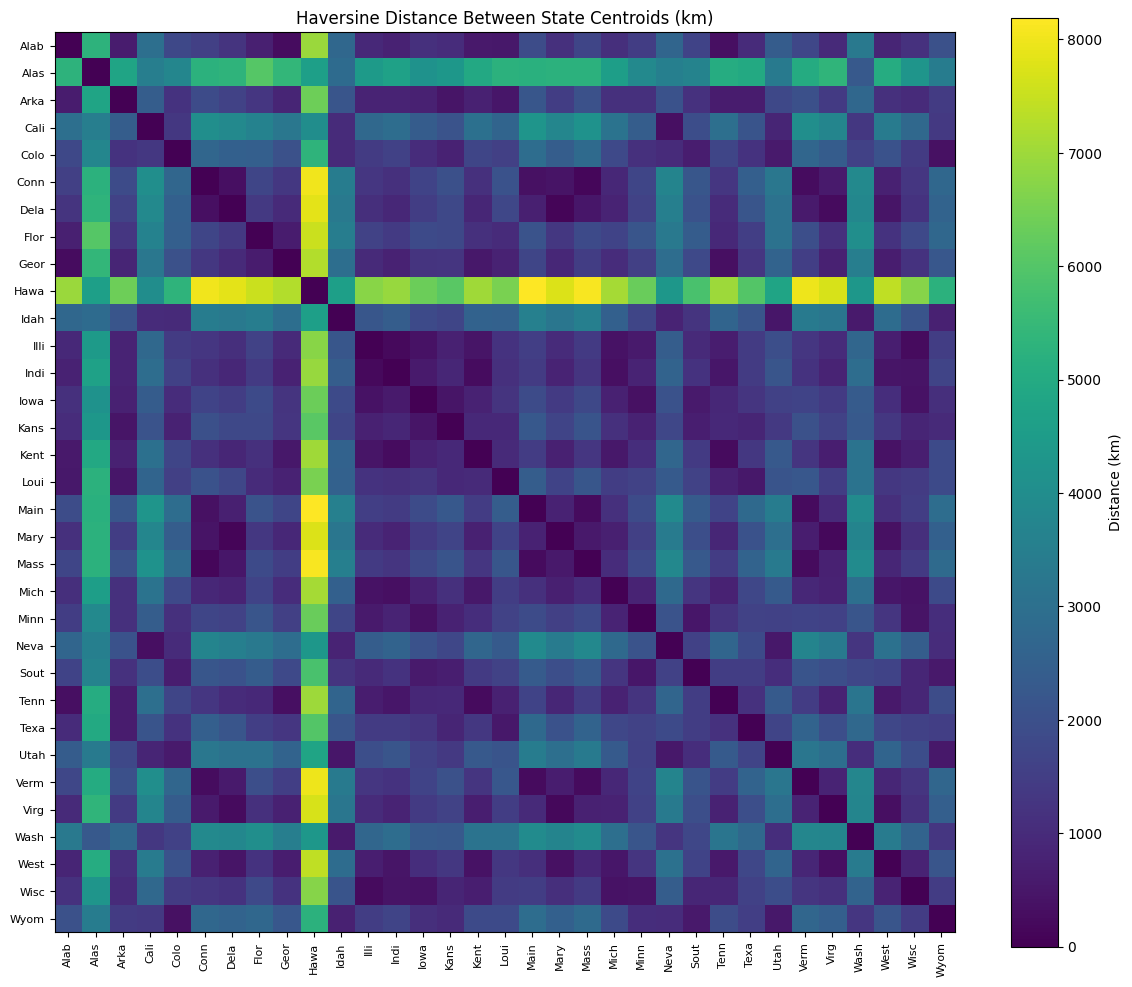

In [12]:
# Visualize distance matrix
fig, ax = plt.subplots(figsize=(12, 10))

# Get state names for labels
state_names_ordered = [STATE_INDEX_TO_NAME.get(idx_to_state[i], f"S{i}") for i in range(len(state_to_idx))]
# Abbreviate names
state_abbrev = [name[:4] for name in state_names_ordered]

im = ax.imshow(distance_matrix, cmap='viridis')
ax.set_xticks(range(len(state_abbrev)))
ax.set_yticks(range(len(state_abbrev)))
ax.set_xticklabels(state_abbrev, rotation=90, fontsize=8)
ax.set_yticklabels(state_abbrev, fontsize=8)
ax.set_title('Haversine Distance Between State Centroids (km)')
plt.colorbar(im, label='Distance (km)')
plt.tight_layout()
plt.show()

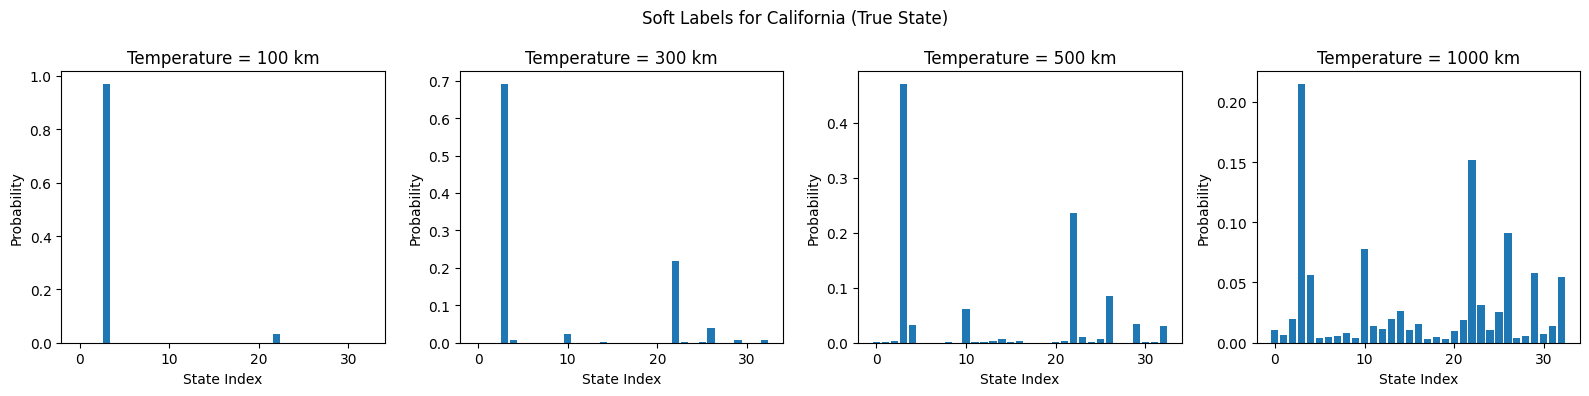

In [13]:
# Visualize soft labels for a sample state
from src.data.state_utils import get_soft_labels

# Pick California as example (if in dataset)
example_state_orig = 4  # California
if example_state_orig in state_to_idx:
    example_state = state_to_idx[example_state_orig]
    example_name = "California"
else:
    example_state = 0
    example_name = STATE_INDEX_TO_NAME.get(idx_to_state[0], "Unknown")

# Get soft labels with different temperatures
temps = [100, 300, 500, 1000]

fig, axes = plt.subplots(1, len(temps), figsize=(16, 4))

for ax, temp in zip(axes, temps):
    soft_labels = get_soft_labels(example_state, distance_matrix, temperature=temp)
    ax.bar(range(len(soft_labels)), soft_labels.numpy())
    ax.set_title(f'Temperature = {temp} km')
    ax.set_xlabel('State Index')
    ax.set_ylabel('Probability')

plt.suptitle(f'Soft Labels for {example_name} (True State)')
plt.tight_layout()
plt.show()

## 4. Create DataLoaders

In [14]:
from src.data.dataloader import create_dataloaders

# Create train and validation dataloaders
train_loader, val_loader, label_encoder = create_dataloaders(config, return_encoder=True)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Number of classes: {label_encoder.num_classes}")

Found 33 unique states in the dataset
Total samples: 65980
Loaded existing state centroids
Loaded existing haversine matrix
Train size: 59382, Val size: 6598

Train batches: 1855
Val batches: 207
Number of classes: 33


In [15]:
# Test a batch
batch = next(iter(train_loader))

print("Batch contents:")
for key, value in batch.items():
    if torch.is_tensor(value):
        print(f"  {key}: {value.shape}, dtype={value.dtype}")
    else:
        print(f"  {key}: {type(value)}")

/Users/chetan/Desktop/geoguessr-competition/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch contents:
  images: torch.Size([32, 4, 3, 336, 336]), dtype=torch.float32
  sample_id: torch.Size([32]), dtype=torch.int64
  state_idx: torch.Size([32]), dtype=torch.int64
  state_label: torch.Size([32]), dtype=torch.int64
  latitude: torch.Size([32]), dtype=torch.float32
  longitude: torch.Size([32]), dtype=torch.float32
  gps: torch.Size([32, 2]), dtype=torch.float32


## 5. Model Setup

In [16]:
from src.models.geoguessr_model import GeoGuessrModel

# Create model
model = GeoGuessrModel(config, num_classes=label_encoder.num_classes)
model = model.to(device)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Cancellation requested; stopping current tasks.


KeyboardInterrupt: 

In [ ]:
# Test forward pass
with torch.no_grad():
    test_images = batch['images'].to(device)
    outputs = model(test_images)
    
print("Model outputs:")
for key, value in outputs.items():
    print(f"  {key}: {value.shape}")

## 6. Loss Function Setup

In [ ]:
from src.training.losses import create_loss_function

# Create loss function with haversine smoothing
loss_fn = create_loss_function(config, distance_matrix)
loss_fn = loss_fn.to(device)

print("Loss function created with:")
print(f"  Classification weight: {config.training.classification_weight}")
print(f"  GPS weight: {config.training.gps_weight}")
print(f"  Haversine smoothing: {config.training.use_haversine_smoothing}")
print(f"  Temperature: {config.training.haversine_temperature} km")

In [ ]:
# Test loss computation
with torch.no_grad():
    test_images = batch['images'].to(device)
    test_labels = batch['state_label'].to(device)
    test_gps = batch['gps'].to(device)
    
    outputs = model(test_images)
    losses = loss_fn(
        outputs['class_logits'],
        outputs['gps_coords'],
        test_labels,
        test_gps
    )
    
print("Test loss computation:")
for key, value in losses.items():
    print(f"  {key}: {value.item():.4f}")

## 7. Training Phase 1: Frozen Backbone

Train only the classification and GPS heads with the backbone frozen.

In [ ]:
from src.training.trainer import Trainer

# Create trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    config=config,
    device=device
)

In [ ]:
# Train with frozen backbone
history_frozen = trainer.train(
    num_epochs=config.training.num_epochs_frozen,
    phase="frozen",
    save_dir=config.paths.checkpoints_dir
)

In [ ]:
# Plot training curves
from src.utils.visualization import plot_training_curves

plot_training_curves(history_frozen, save_path=config.paths.logs_dir / "frozen_training.png")

## 8. Training Phase 2: Fine-tuning

Unfreeze backbone and fine-tune the entire model with lower learning rate.

In [ ]:
# Load best frozen checkpoint if needed
best_frozen_path = config.paths.checkpoints_dir / "best_frozen.pt"
if best_frozen_path.exists():
    trainer.load_checkpoint(best_frozen_path)

In [ ]:
# Fine-tune with unfrozen backbone
history_finetune = trainer.train(
    num_epochs=config.training.num_epochs_finetune,
    phase="finetune",
    save_dir=config.paths.checkpoints_dir
)

In [ ]:
# Plot combined training curves
combined_history = {
    'train_loss': history_frozen['train_loss'] + history_finetune['train_loss'],
    'val_loss': history_frozen['val_loss'] + history_finetune['val_loss'],
    'val_score': history_frozen['val_score'] + history_finetune['val_score'],
    'learning_rates': history_frozen['learning_rates'] + history_finetune['learning_rates']
}

plot_training_curves(combined_history, save_path=config.paths.logs_dir / "full_training.png")

## 9. Evaluation & Analysis

In [ ]:
# Load best model
best_path = config.paths.checkpoints_dir / "best_finetune.pt"
if best_path.exists():
    trainer.load_checkpoint(best_path)

# Final validation
final_metrics = trainer.validate()

print("\n" + "="*50)
print("Final Validation Results")
print("="*50)
print(f"Competition Score: {final_metrics['final_score']:.4f}")
print(f"  Classification Score: {final_metrics['classification_score']:.4f}")
print(f"  GPS Score: {final_metrics['gps_score']:.4f}")
print(f"\nGPS Metrics:")
print(f"  Mean Distance: {final_metrics['gps_gps_mean_distance_km']:.1f} km")
print(f"  Median Distance: {final_metrics['gps_gps_median_distance_km']:.1f} km")

In [ ]:
# Generate predictions on validation set for analysis
from src.inference.predict import predict_dataset

val_predictions = predict_dataset(
    model=model,
    dataloader=val_loader,
    device=device,
    top_k=5,
    use_amp=config.training.use_amp,
    idx_to_state=label_encoder.idx_to_state
)

print(f"Generated predictions for {len(val_predictions['sample_ids'])} samples")

In [ ]:
# Visualize GPS predictions
from src.utils.visualization import plot_gps_predictions

plot_gps_predictions(
    val_predictions['latitudes'],
    val_predictions['longitudes'],
    save_path=config.paths.logs_dir / "gps_predictions.png"
)

In [ ]:
# State prediction distribution
from src.utils.visualization import plot_state_distribution

plot_state_distribution(
    val_predictions['top_k_states'][:, 0],  # Top-1 predictions
    STATE_INDEX_TO_NAME,
    title="Validation Set - Predicted State Distribution",
    save_path=config.paths.logs_dir / "state_predictions.png"
)

## 10. Generate Test Predictions & Submission

In [ ]:
from src.data.dataloader import create_test_dataloader

# Create test dataloader
test_loader = create_test_dataloader(config, label_encoder.state_to_idx)
print(f"Test batches: {len(test_loader)}")

In [ ]:
# Generate predictions
test_predictions = predict_dataset(
    model=model,
    dataloader=test_loader,
    device=device,
    top_k=5,
    use_amp=config.training.use_amp,
    idx_to_state=label_encoder.idx_to_state
)

print(f"Generated predictions for {len(test_predictions['sample_ids'])} test samples")

In [ ]:
from src.inference.submission import create_submission, analyze_submission

# Create submission file
submission_path = config.paths.submissions_dir / "submission.csv"

submission = create_submission(
    predictions=test_predictions,
    template_path=str(config.paths.test_csv),
    output_path=str(submission_path),
    validate=True
)

In [ ]:
# Analyze submission
analysis = analyze_submission(submission)

print("Submission Analysis:")
print(f"  Unique states predicted: {analysis['num_unique_states']}")
print(f"  Latitude range: {analysis['lat_range']}")
print(f"  Longitude range: {analysis['lon_range']}")

# Top 5 most predicted states
print("\nTop 5 most predicted states:")
for state_idx, count in sorted(analysis['state_distribution'].items(), key=lambda x: -x[1])[:5]:
    state_name = STATE_INDEX_TO_NAME.get(int(state_idx), f"Unknown ({state_idx})")
    print(f"  {state_name}: {count}")

In [ ]:
# View submission
submission.head(10)

## 11. (Optional) Ensembling

If you've trained multiple models, ensemble their predictions.

In [ ]:
# Example: Load multiple model predictions and ensemble
# This is a template - you'd need multiple trained models

# from src.inference.ensemble import ensemble_predictions, weighted_ensemble

# predictions_list = [
#     test_predictions,  # Model 1
#     # test_predictions_2,  # Model 2
#     # test_predictions_3,  # Model 3
# ]

# val_scores = [
#     final_metrics['final_score'],  # Model 1 val score
#     # 0.75,  # Model 2 val score
#     # 0.73,  # Model 3 val score
# ]

# ensembled = weighted_ensemble(predictions_list, val_scores)

## Summary

Training complete! Key files generated:

- **Checkpoints**: `checkpoints/best_frozen.pt`, `checkpoints/best_finetune.pt`
- **Submission**: `submissions/submission.csv`
- **Logs**: `outputs/training_logs/`

Next steps:
1. Submit `submissions/submission.csv` to Kaggle
2. Review training curves and adjust hyperparameters
3. Train additional models for ensembling
4. Experiment with different haversine temperatures